# Assignment 1

This assignment covers material from Weeks 1–4. Think of it as a spot-check: five exercises that test important analytical and visualization skills from the first part of the course.

## Formalia:

<mark>Please read the **[assignment overview page](https://github.com/suneman/socialdata2026/wiki/Assignments)** carefully before proceeding.</mark> This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

***If you fail to follow these simple instructions, it will negatively impact your grade!***

**Due date and time**: The assignment is due on Monday March 2nd, 2026 at 23:55. Hand in your files via DTU Learn. 

## Important Notes:
**All exercises use your combined SF crime dataset** (2003–present) that you built during Week 2, along with your Personal Focus Crimes. Make sure you have those ready before you start.
* **Hint**: The number of focus crimes are up to you, but choosing very few focus-crimes (1-5, let's say) feels like taking the easy way out to me, so to get top marks, you'll need 8 or more focus crimes (but it's not that more are better, 16 isn't necessarily better than 8).

Each assignment draws directly on the weekly exercises - you should be able to pull your work directly from there.

<div class="alert alert-block alert-info">
The same LLM guidance applies here as during the weekly exercises: use your LLM freely for coding, pandas syntax, and plot formatting. Do not use it for interpretation, reflection, or anything that asks for your own thinking. 
<br>  <br>
If you use and LLM to cheat, you are missing out on your education ... it will mean that you're not getting all you can out of this class ... and, more importantly, that you are literally wasting this crucial time of your DTU-journey, designed to make you smarter and ready for the world.
</div>

---
## Assignment 1.1: Temporal Overview

Let's start by getting the big picture of how crime has changed over the full 20+ year period covered by your combined dataset.

*Draws from*: Week 1, Exercises 4.1 and 4.2 — applied here to the full merged dataset (2003–present) rather than just 2018–present.

> * Using your combined dataset (2003–present), plot the total number of incidents **per year** for each of your Personal Focus Crimes. Display at least the years 2003–2025. 
> * Make sure your plot follows good visualization practices: labeled axes, a legend, a descriptive title.
> * Identify and comment on at least two notable features in the plot — for example, long-term trends, sudden drops or spikes, or the impact of COVID-19 in 2020. For each feature, offer a possible explanation.

In [1]:
import pandas as pd
df = pd.read_csv('~/OneDrive/Desktop/sdav/exercises/data/merged_sfpd.csv')

In [2]:
personal_focus = [
    'larceny/theft',
    'non-criminal',
    'assault',
    'vehicle theft',
    'drug/narcotic',
    'vandalism',
    'warrants',
    'burglary',
    'suspicious occ'
]
df_pf = df[df['incident_category'].isin(personal_focus)].copy()

---
## Assignment 1.2: Crime Profiles by Police District

Different parts of the city have very different crime patterns. Here we quantify that using conditional probabilities.

*Draws from*: Week 3, Exercises 2.1 and 2.2.

> * For each police district in your dataset, compute the **conditional crime profile**: for each of your Personal Focus Crimes, calculate
>
>   $$r(\text{crime}, \text{district}) = \frac{P(\text{crime} \mid \text{district})}{P(\text{crime})}$$
>
>   A value above 1 means that crime type is *over-represented* in that district relative to the city-wide average; below 1 means it is *under-represented*.
> * Visualize these ratios in a way that makes it easy to compare across both districts and crime types. (Simple barcharts are fine, but you may also use ideas from more complex visualization techniques, for example, a heatmap could work well here, but you're free to choose another format if you can justify it.)
> * Pick **one district** whose profile stands out to you. Describe the pattern and offer an explanation for why that district looks the way it does. Are there geographic, demographic, or other factors that might explain it?

In [3]:
prob_crime_district = df_pf.groupby('police_district')['incident_category'].value_counts(normalize=True).unstack().fillna(0)
prob_crime = df_pf['incident_category'].value_counts(normalize=True)

districts = sorted(df_pf['police_district'].dropna().unique().tolist())
crimes = sorted(df_pf['incident_category'].dropna().unique().tolist())

cond_probs = {crime: (prob_crime_district[crime] / prob_crime[crime]).to_dict() for crime in crimes}

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

cond_probs = pd.DataFrame(cond_probs)

# Calculate sums for marginal bar charts
row_sums = df_pf['police_district'].value_counts(normalize=True).sort_index()
col_sums = prob_crime.sort_index()

# Create figure with subplots using GridSpec
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[1, 8], 
              hspace=0.05, wspace=0.05)

# Main heatmap
ax_main = fig.add_subplot(gs[1, 0])
im = ax_main.imshow(cond_probs.T, cmap='Blues', aspect='auto')
ax_main.set_xticks(range(len(districts)))
ax_main.set_xticklabels(districts, rotation=90)
ax_main.set_yticks(range(len(crimes)))
ax_main.set_yticklabels(crimes)
ax_main.set_xlabel('Police District')
ax_main.set_ylabel('Crime Category')

# Text annotations
for i in range(cond_probs.shape[0]):
    for j in range(cond_probs.shape[1]):
        val = cond_probs.iloc[i, j]
        ax_main.text(i, j, f"{val:.2f}", ha='center', va='center', 
                    color='black', fontsize=8+(1.5*val))

# Column Sums
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.bar(range(len(districts)), row_sums, color='cornflowerblue', alpha=0.7)
ax_top.set_ylabel('Prob')
ax_top.tick_params(labelbottom=False)
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.grid(axis='y', linestyle='--', alpha=0.7)

# Row Sums
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_right.barh(range(len(crimes)), col_sums, color='cornflowerblue', alpha=0.7)
ax_right.set_xlabel('Prob')
ax_right.tick_params(labelleft=False)
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.grid(axis='x', linestyle='--', alpha=0.7)

fig.suptitle('Conditional Probabilities of Police Districts Given Crimes', fontsize=14, y=0.98)

plt.show()

Above we see a visualization of the various types of crimes committed in the 11 districts of San Francisco. The data is visualized as a heatmap, in which each cell represents the conditional probability of a given crime in a given district. Thus, a value higher than one means that that crime is occurring more often than average, in the district. Above and to the right of the heatmap you see two bar charts. The top one shows the unconditional probability that if a crime occurs, it is in that given district. While the right bar chart shows the unconditional probability that if a crimes occurs, it is that crime (OBS. probabilities are only normalized with focus crimes, and not the total data set).

When looking at the plot two thing become clear. Firstly, a very small amount of the crimes registered are "ouf of sf". This district is quite high in the "non-criminal" category. This suggests that SF Police is called out of the city, every now and then, to simply declare that something is perfectly legal. If it is a crime, it is most likely someone stealing something, either a car or something else. In and of itself, this is not that interesting, but considering that this is a data set for crime in San Francisco, it is curious that we have a district called "Out of San Francisco" and a category called "non-criminal".
Moving on to SF we can see some interesting patterns. One that spring to mind is what is happening in the "Southern" district. This district does not spike out in any category, like we see with Tenderloin and drugs, instead it rests at a steady rate for each crime. In total, this district has the most crime, as seen in top bar chart. This suggests that criminals here are less picky at what crimes they commit, and instead try for a quantity over quality tactic. The most out-of-distribution crime in this district falls on the category "warrants", which in itself isn't a crime but typically suggests that a police investigation needs special permissions. Putting that together it seems that the Southern district of SF is one of the more "harsh" neighborhoods, and also one of the most policed. Which one causes the other, one can wonder?

---
## Assignment 1.3: Visualizing Distributions

This exercise asks you to recreate several classic plot types from DAOST Chapter 2 using your own crime data — putting visualization theory into practice.

*Draws from*: Week 3, Exercises 5.2 and 5.3.

> **Part A — Jitter plot**
> * Pick one of your Personal Focus Crimes and a suitable time interval (somewhere between a month and 6 months, depending on how common the crime is). Create a jitter plot of the incident times during a single hour (e.g. 13:00–14:00): let time run along the $x$-axis and add vertical jitter.
> * What does the jitter plot reveal about how times are recorded in the dataset? Are incidents clustered at certain minutes (on the hour, half hour, etc.)? What does this tell you about the precision of the data?
>
> **Part B — Probability plot**
> * Using the same geographic data from Part B, create a probability plot (QQ plot) for the latitude distribution of each of your two crime types. (`scipy.stats.probplot` is your friend here.)
> * What reference distribution are you comparing against? What would it mean if the points fell exactly on the straight line? Where does the distribution deviate from normal, and what does that deviation tell you about the geography of crime in SF?
>
> **Part C — Box plots of time-of-day**
> * For each of your Personal Focus Crimes, extract the time-of-day of every incident.
> * Create box plots showing the time-of-day distribution for all your Personal Focus Crimes side by side.
> * What patterns do you see? Are there crimes that happen mostly at night? Mostly during business hours? For crimes that peak late at night, does the box plot handle the wrap-around at midnight well? What goes wrong?
> * Above, feel free to use alternatives to box plots — violin plots, swarm plots, or raincloud plots — if you think they reveal more. If you do, briefly explain what the alternative shows that the box plot doesn't.

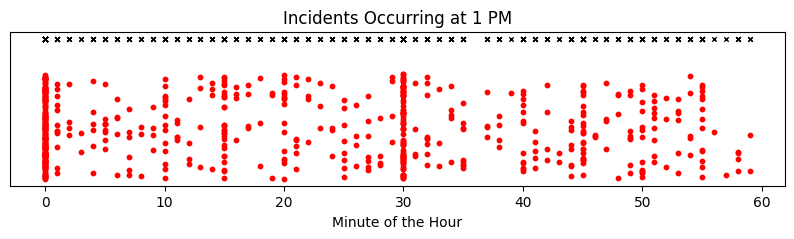

In [5]:
import matplotlib.pyplot as plt
import numpy as np

df_pf['incident_time'] = pd.to_datetime(df_pf['incident_time'], format='%H:%M:%S')
df_pf['hour'] = df_pf['incident_time'].dt.hour
df_pf['minute'] = df_pf['incident_time'].dt.minute
hour13 = df_pf[(df_pf['incident_date'] > '2025-06-01') & (df_pf['incident_date'] < '2025-12-31') & (df_pf['hour'] == 13) & (df_pf['incident_category'] == 'larceny/theft')]

plt.figure(figsize=(10, 2))
plt.scatter(hour13['minute'], [0.2]*len(hour13), 10, marker='x', color='black', linewidths=1)
plt.scatter(hour13['minute'], np.random.uniform(0, 0.15, len(hour13)), 10, marker='o', color='red', linewidths=1)
plt.yticks([])
plt.xlabel('Minute of the Hour')
plt.title('Incidents Occurring at 1 PM')
plt.show()

The jitter plot above shows us when, during the 13th hour of the day, that crimes are registered. Without being critical toward the data source it would seem that criminals are politely waiting for "nice" time-slots for getting caught. We see that most crimes occur at the whole hour and second most at the half hour. There is also a noticeable part at the first quarter, but funnily enough the third quarter is much less pronounced. Of course this is due to a "laziness" from the police officers as they note the time of the crime occurrence. What is less obvious is why there is a tendency to note the first quarter and not the third. Is there truly more crime in the first half hour or is there some hidden systematical error in the data at this point?

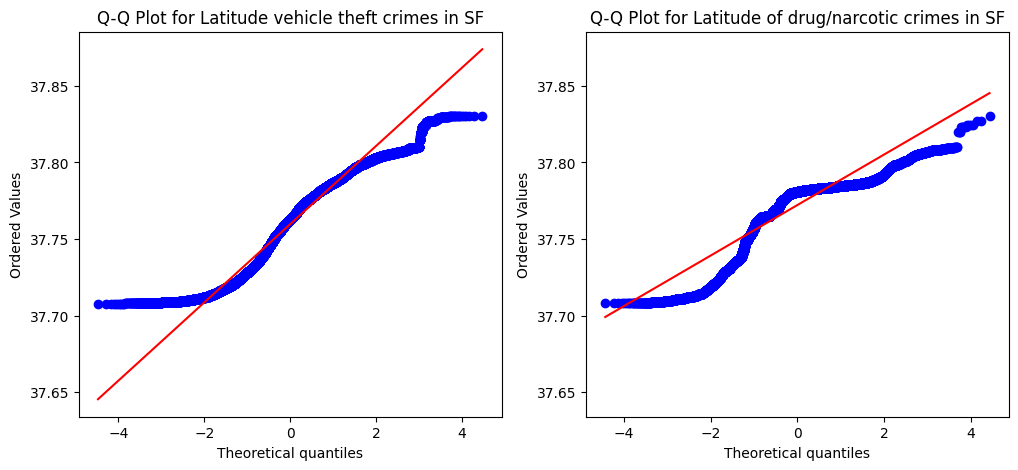

In [6]:
from scipy.stats import probplot
crimes = ['vehicle theft', 'drug/narcotic']
df_pf = df_pf[df_pf['latitude'] < 80]

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
probplot(df_pf[df_pf['incident_category'] == crimes[0]]['latitude'], dist="norm", plot=plt)
plt.title(f'Q-Q Plot for Latitude {crimes[0]} crimes in SF')
plt.subplot(1, 2, 2, sharey=ax)
probplot(df_pf[df_pf['incident_category'] == crimes[1]]['latitude'], dist="norm", plot=plt)
plt.title(f'Q-Q Plot for Latitude of {crimes[1]} crimes in SF')
plt.show()

Here we are investigating the latitude distribution of two specific crimes; vehicle theft and drugs. The Q-Q plots above matches the distribution of latitude coordinates to a normal distribution. Had the blue lines followed the red, the data would have been perfectly normal. That is not the case. For the vehicle thefts in the left plot we see a high tail in the lower end of the plot. This means that the data is skewed to the left, compared to a normal distribution. In geographical terms, it means that a surplus of vehicle thefts happen in the southern regions of SF. Thinking back to part 1.2 of this assignment, that makes a lot of sense, since the most crime happens in the southern district. Logically, it makes sense since "downtown" SF is in the northern part of the city, meaning that the majority of cars are probably to the south.

Looking a bit to the right we see the latitude distribution of the drug/narcotics crimes. Now, these are quite different. Here there is a high region in the middle meaning that the distribution is rather hyper-normal. Again in geographical terms, it seems that the central regions of SF is where people a caught doing drugs. Putting this into perspective is a bit hard, without knowing the city. But from an objective standpoint one would assume that the the smaller "off-broadway" streets located far enough from downtown to be on spotlight, but close enough to still be in the city would be a good place for a party or perhaps a drug den.

In either case it seems that the downtown area is kept somewhat clean from these categories of crimes.
 

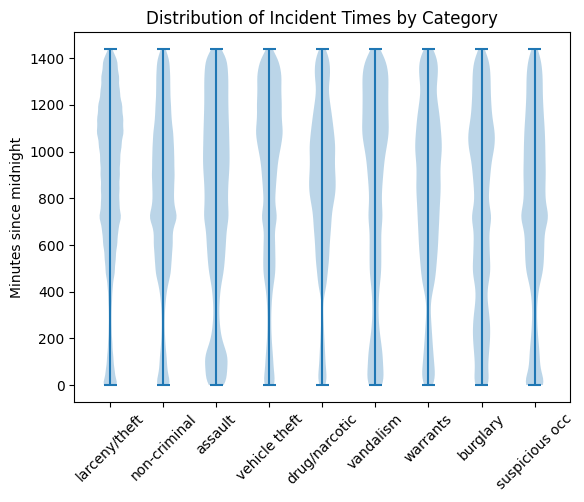

In [7]:
data = df_pf.copy()

data['time_since_midnight'] = data['hour'] * 60 + data['minute']
df = {cat: data[data['incident_category'] == cat]['time_since_midnight'] for cat in personal_focus}

plt.violinplot(list(df.values()), positions=list(range(len(df))))
plt.xticks(list(range(len(df))), list(df.keys()), rotation=45)
plt.ylabel("Minutes since midnight")
plt.title("Distribution of Incident Times by Category")
plt.show()

In the plot you see a distribution of the time of day for each focus category of crime. For this task, we have chosen the slightly niche violin-plot, instead of the usual boxplot. This is done to avoid the otherwise big fallacy of visualizing days as a non-circular timeframe. For a regular boxplot we would usually see an average at the middle of the day, this is true for a crime, which mostly occurs in the evening / at night, or a crime which mostly occurs during mid day. For the violinplot we instead see the explicit distribution, allowing the viewer to decide when a crime mostly occurs. E.g. in the case we see that larceny/theft is a crime most occurring in the evening/night hours, but dies out later during the night. On the opposite side we see the drug crimes mostly happen during the day/evening, which is opposite to what one might believe. Unsurprisingly though, burglary can be seen to occur somewhat evenly throughout all 24 hours.

The jitter plot above shows us when, during the 13th hour of the day, that crimes are registered. Without being critical toward the data source it would seem that criminals are politely waiting for "nice" time-slots for getting caught. We see that most crimes occur at the whole hour and second most at the half hour. There is also a noticeable part at the first quarter, but funnily enough the third quarter is much less pronounced. Of course this is due to a "laziness" from the police officers as they note the time of the crime occurrence. What is less obvious is why there is a tendency to note the first quarter and not the third. Is there truly more crime in the first half hour or is there some hidden systematical error in the data at this point?

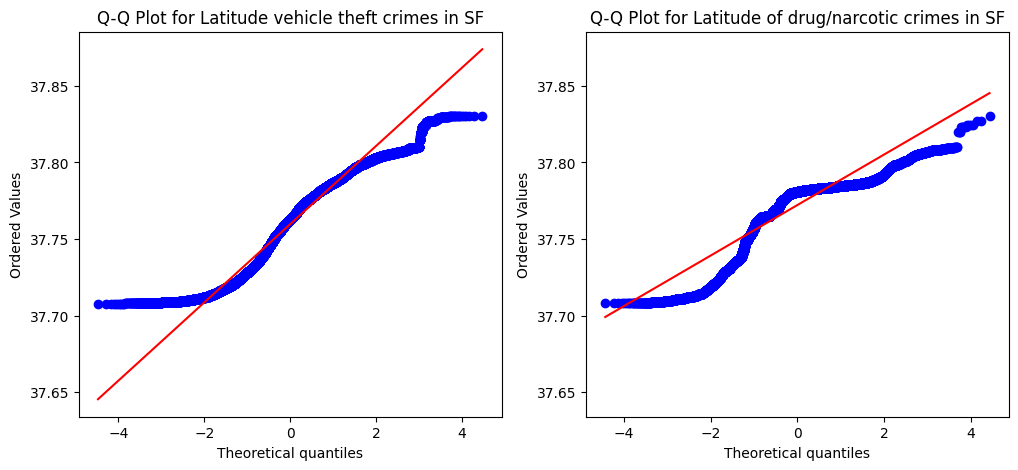

In [6]:
from scipy.stats import probplot
crimes = ['vehicle theft', 'drug/narcotic']
df_pf = df_pf[df_pf['latitude'] < 80]

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
probplot(df_pf[df_pf['incident_category'] == crimes[0]]['latitude'], dist="norm", plot=plt)
plt.title(f'Q-Q Plot for Latitude {crimes[0]} crimes in SF')
plt.subplot(1, 2, 2, sharey=ax)
probplot(df_pf[df_pf['incident_category'] == crimes[1]]['latitude'], dist="norm", plot=plt)
plt.title(f'Q-Q Plot for Latitude of {crimes[1]} crimes in SF')
plt.show()

Here we are investigating the latitude distribution of two specific crimes; vehicle theft and drugs. The Q-Q plots above matches the distribution of latitude coordinates to a normal distribution. Had the blue lines followed the red, the data would have been perfectly normal. That is not the case. For the vehicle thefts in the left plot we see a high tail in the lower end of the plot. This means that the data is skewed to the left, compared to a normal distribution. In geographical terms, it means that a surplus of vehicle thefts happen in the southern regions of SF. Thinking back to part 1.2 of this assignment, that makes a lot of sense, since the most crime happens in the southern district. Logically, it makes sense since "downtown" SF is in the northern part of the city, meaning that the majority of cars are probably to the south.

Looking a bit to the right we see the latitude distribution of the drug/narcotics crimes. Now, these are quite different. Here there is a high region in the middle meaning that the distribution is rather hyper-normal. Again in geographical terms, it seems that the central regions of SF is where people a caught doing drugs. Putting this into perspective is a bit hard, without knowing the city. But from an objective standpoint one would assume that the the smaller "off-broadway" streets located far enough from downtown to be on spotlight, but close enough to still be in the city would be a good place for a party or perhaps a drug den.

In either case it seems that the downtown area is kept somewhat clean from these categories of crimes.
 

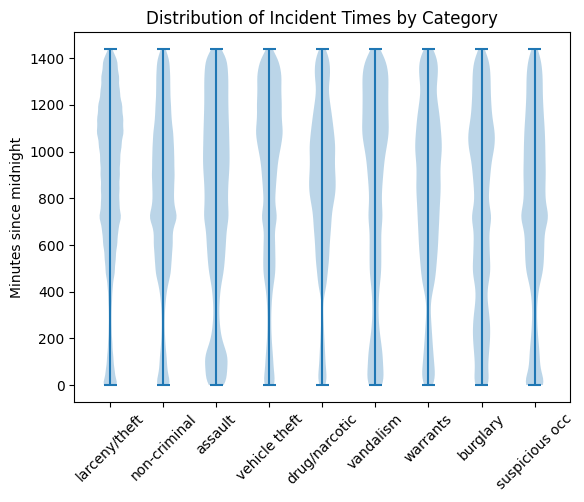

In [7]:
data = df_pf.copy()

data['time_since_midnight'] = data['hour'] * 60 + data['minute']
df = {cat: data[data['incident_category'] == cat]['time_since_midnight'] for cat in personal_focus}

plt.violinplot(list(df.values()), positions=list(range(len(df))))
plt.xticks(list(range(len(df))), list(df.keys()), rotation=45)
plt.ylabel("Minutes since midnight")
plt.title("Distribution of Incident Times by Category")
plt.show()

In the plot you see a distribution of the time of day for each focus category of crime. For this task, we have chosen the slightly niche violin-plot, instead of the usual boxplot. This is done to avoid the otherwise big fallacy of visualizing days as a non-circular timeframe. For a regular boxplot we would usually see an average at the middle of the day, this is true for a crime, which mostly occurs in the evening / at night, or a crime which mostly occurs during mid day. For the violinplot we instead see the explicit distribution, allowing the viewer to decide when a crime mostly occurs. E.g. in the case we see that larceny/theft is a crime most occurring in the evening/night hours, but dies out later during the night. On the opposite side we see the drug crimes mostly happen during the day/evening, which is opposite to what one might believe. Unsurprisingly though, burglary can be seen to occur somewhat evenly throughout all 24 hours.

---
## Assignment 1.4: Spatial Power Law

Is crime spread evenly across San Francisco, or is it concentrated in a small number of hotspots? Let's find out.

*Draws from*: Week 4, Exercise 2.2.

Use your **most common Personal Focus Crime** (by total incident count) for this exercise.

> * **Step 1**: Divide San Francisco into a grid of approximately $100\text{m} \times 100\text{m}$ cells using latitude and longitude. It is fine to ignore that the Earth isn't flat — the approximation is good enough for this purpose.
>     * **Hint**: `np.histogram2d` works well here. Focus on points within the SF peninsula; filter out geographic outliers.
> * **Step 2**: Count the number of incidents of your chosen crime in each grid cell (use all years of data).
> * **Step 3**: Tally the distribution. Count how many cells have exactly $k$ incidents — call this $N(k)$ — for $k = 0, 1, 2, \ldots$ up to the maximum.
> * **Step 4**: Plot $(k+1)$ vs $N(k)$ on **linear axes**.
> * **Step 5**: Plot $(k+1)$ vs $N(k)$ on **loglog axes**.
> * **Step 6**: Does your crime follow a power-law spatial distribution? How can you tell from the loglog plot?
> * **Step 7**: If crime is spatially concentrated in a small number of cells, what does that imply for how we interpret neighborhood-level crime statistics? Does the "average block" tell you anything useful?

---
## Assignment 1.5: Regression and Correlation

Which of your Personal Focus Crimes share the most similar weekly rhythm — and which are completely out of sync?

*Draws from*: Week 4, Exercises 3.1, 3.2, and 3.3.

Select **at least 4** of your Personal Focus Crimes for this exercise. More is fine - if you want to be closer to the actual weekly exercise.

> * For each selected crime type, compute the total number of incidents for each of the **168 hours of the week** (i.e., Monday 00:00–01:00, Monday 01:00–02:00, ..., Sunday 23:00–00:00). Each crime type will give you a vector of 168 values.
>
> * **Scatterplot matrix**: Create a grid of pairwise scatterplots — one panel per pair of crime types, with one crime on each axis and each of the 168 hours as a point. Label each panel clearly with the two crime types being compared.
>
> * **Linear regression**: Using the closed-form equations from Week 4 (not a library), fit a regression line $y = ax + b$ to each pair and add it to the relevant panel:
>   $$a = \frac{\sum_i x_i y_i - N\langle x\rangle\langle y\rangle}{\sum_i x_i^2 - N\langle x\rangle^2}, \qquad b = \langle y \rangle - a\langle x \rangle$$
>
> * **$R^2$**: Compute $R^2$ for each pair and display the value on each panel. 
>
> * Looking at your results: which pair of crimes is **most correlated**? Which is **least correlated**? Does the answer match your intuition? Why might two crime types share a weekly rhythm — or not?